In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Predicting Price Movements of Cryptocurrencies - Using Convolutional Neural Networks to Classify 2D Images of Chart Data

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

# For downloading files
from IPython.display import FileLink, FileLinks

In [2]:
PATH = 'data/btc-trading-patterns2/'
!ls {PATH}

models	test  tmp  train


In [3]:
os.listdir(f'{PATH}train')

['DOWN', 'UP']

In [4]:
files = os.listdir(f'{PATH}train/DOWN')[:5]
files

['a7757722-fef9-43e9-b46c-3a334b247e27.png',
 '10e1f256-795e-4985-8d29-bfa40a6bd873.png',
 '94ee828f-0b4e-4d37-8bf1-078e16472d4b.png',
 '8e63892f-4b57-45d1-b031-52cc3ea24473.png',
 'e244d2ac-3101-406e-b858-2302ce01a9d7.png']

data/btc-trading-patterns2/train/DOWN/a7757722-fef9-43e9-b46c-3a334b247e27.png
data/btc-trading-patterns2/train/DOWN/10e1f256-795e-4985-8d29-bfa40a6bd873.png


/home/liam/crypto-project/fast-crypto-ai/data/btc-trading-patterns2/train/DOWN/8e63892f-4b57-45d1-b031-52cc3ea24473.png

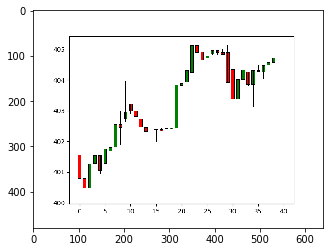

In [5]:
img = plt.imread(f'{PATH}train/DOWN/{files[3]}')
print(f'{PATH}train/DOWN/{files[0]}')
print(f'{PATH}train/DOWN/{files[1]}')
plt.imshow(img)
FileLink(f'{PATH}train/DOWN/{files[3]}')

# The Steps to Follow
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## 0. Setup

In [6]:
arch = resnet34
sz = 299
bsz = int(64)

## 1. Data Augmentation
**Not using data augmentation this time**

Starting without useing data augmentation because I don't think it makes sense for these graphs, we don't need to generalize to slightly different angles. All plots will always be straight on and square in the frame.

In [7]:
tfms = tfms_from_model(arch, sz)

In [8]:
data = ImageClassifierData.from_paths(PATH, bs=bsz, tfms=tfms, 
                                      trn_name='train', val_name='test')

## 2. Choose a Learning Rate

In [12]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [ ]:
lrf = learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learn.save("precomuted_market_movement")

In [ ]:
learn.load("precomuted_market_movement")

In [ ]:
learn.fit(1e-4, 1)

TODO

Do some tests on accuracy of training on single epoch

In [ ]:
learn.save("trained_1_market_movement")

In [14]:
learn.load("trained_1_market_movement")

In [16]:
learn.precompute=False

In [ ]:
learn.fit(1e-4, 3, cycle_len=1)

In [ ]:
learn.save("trained_2_market_movement")

In [17]:
learn.load("trained_2_market_movement")

More accuracy test...

In [ ]:
learn.unfreeze()

Using a relatively large learning rate to train the prvious layers because this data set is not very similar to ImageNet

In [ ]:
lr = np.array([0.0001/9, 0.0001/3, 0.00001])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save("trained_3_market_movement")
learn.load("trained_3_market_movement")

# Look at Results

In [ ]:
data.val_y

In [ ]:
data.classes

In [21]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(100000, 2)

In [22]:
log_preds[:10]

array([[-0.988  , -0.46573],
       [-0.55504, -0.85344],
       [-0.68116, -0.70528],
       [-0.63577, -0.75402],
       [-0.57276, -0.83003],
       [-0.66534, -0.72175],
       [-0.77235, -0.61976],
       [-0.64952, -0.73877],
       [-0.64214, -0.74689],
       [-0.59016, -0.80797]], dtype=float32)

In [23]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
probs

array([0.62768, 0.42595, 0.49397, ..., 0.4671 , 0.52919, 0.47982], dtype=float32)

In [24]:
probs[1]

0.42594925

In [25]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


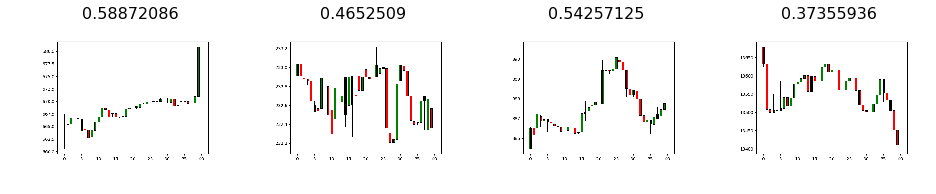

In [26]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [27]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct DOWN


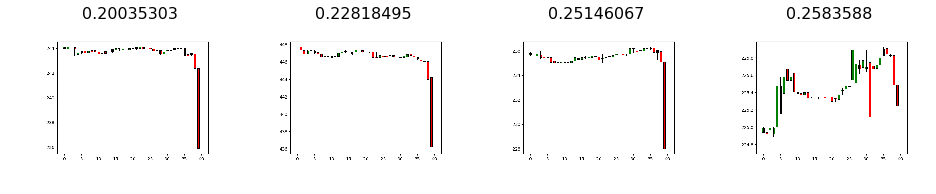

In [28]:
plot_val_with_title(most_by_correct(0, True), "Most correct DOWN")

Most correct UP


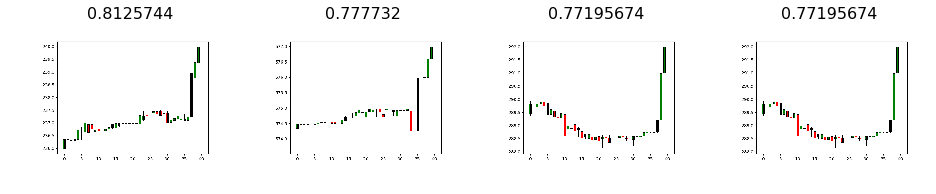

In [29]:
plot_val_with_title(most_by_correct(1, True), "Most correct UP")

Most incorrect DOWN


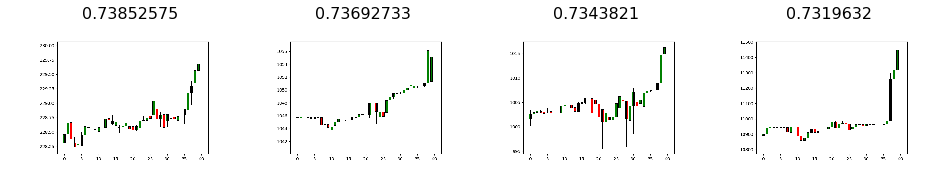

In [30]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect DOWN")

# Analyze Results

In [34]:
preds = np.argmax(probs, axis=1)
probs = preds[:,1]

AxisError: axis 1 is out of bounds for array of dimension 1

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(data.val_y, preds)

[[27174 21655]
 [20658 30513]]


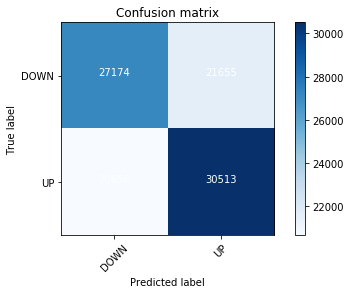

In [40]:
plot_confusion_matrix(cm, data.classes)

In [41]:
cm

array([[27174, 21655],
       [20658, 30513]])

In [43]:
(27174+30513)/(np.sum(cm))

0.57687

In [45]:
np.sum(cm)-(42313)

57687